<a href="https://colab.research.google.com/github/PrincetonUniversity/intro_machine_learning/blob/main/day4/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

Gage DeZoort

Wintersession 2025

*Adapted from a helpful conversation with ChatGPT.*


## 0. Imports

In [1]:
%matplotlib inline

!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.




The goal of this tutorial is to train a sequence-to-sequence



## 1. The Learning Task





Given a word or sequence of words, how likely is some subsequent word? This is a fundamental language modeling task: assigning a likelihood probability to a word to follow some input sequence.


As an example, let's consider the following input sequence:

*I need to take my dog to the vet because he is*

What's the next word? *Hungry*? *Healthy*? *Sick*?

You get the picture.

### 1.1 Tokenization

Machines need to analyze *tokenized* data. Tokens can be words, phrases, characters, etc. They have corresponding `IDs` that are stored in a lookup table.

We're going to use a model called *BERT* (Bidirectional Transformers) as our tokenizer. BERT is a transformer model, whose tokenizer splits the input text into words and punctuation, ignoring whitespace. It also splits complicated words into subwords. See below how the string `"deeeep"` which does not appear in the English language, is split into three tokens `['dee', '##ee', '##p']`. The latter two tokens are called *subwords*.

Google's propriatary WordPiece algorithm is used to build BERT's vocabulary (of subwords) built iteratively from an initial vocab of single character tokens. Frequent character pairs are merged into new subwords until its 30,000 token vocabulary is constructed.





In [2]:
from transformers import AutoTokenizer

# Choose a pre-trained model tokenizer (e.g., BERT)
model_name = "bert-base-uncased" # 100M parameters, not case-sensitive
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example: Tokenizing text
text = "Transformers are a type of deeeep learning model used for NLP tasks. Epehmeral. Anachronism."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Converting tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

# Decoding token IDs back to text
decoded_text = tokenizer.decode(token_ids)
print("Decoded Text:", decoded_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokens: ['transformers', 'are', 'a', 'type', 'of', 'dee', '##ee', '##p', 'learning', 'model', 'used', 'for', 'nl', '##p', 'tasks', '.', 'ep', '##eh', '##meral', '.', 'ana', '##ch', '##ron', '##ism', '.']
Token IDs: [19081, 2024, 1037, 2828, 1997, 9266, 4402, 2361, 4083, 2944, 2109, 2005, 17953, 2361, 8518, 1012, 4958, 11106, 28990, 1012, 9617, 2818, 4948, 2964, 1012]
Decoded Text: transformers are a type of deeeep learning model used for nlp tasks. epehmeral. anachronism.


### 1.2 Sequence Data


To create a coherent learning task, we need to take sequences of tokens and batch them into inputs with corresponding targets. Sequences are batched into uniform-length chunks. For example consider two words written as sequences of tokens:

Sequence #1: `["run", "##ner"]`

Sequence #2: `["d", "##run", "#k", "##en"]`

Our model will expect fixed-size sequences at input, say of size `max_length=3`. Sequence #1 is shorter than `max_length`, so we have to *pad* it with some default value. In BERT, this default value is `[PAD]`. Sequence #2, on the other hand, is longer than `max_length`, so we have to *truncate* it.

In [3]:
# Padding and truncation

sequence = tokenizer(text, padding="max_length", truncation=True, max_length=10)
print("Encoded Sequence:", sequence)
tokenizer.decode(sequence["input_ids"])

Encoded Sequence: {'input_ids': [101, 19081, 2024, 1037, 2828, 1997, 9266, 4402, 2361, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


'[CLS] transformers are a type of deeeep [SEP]'

Here, the `input_IDs` are what the BERT transformer will actually process, the `token_type_ids` are used to demarkate segments (for next-sentence prediction), and the `attention_mask` indicates which tokens are padding (0). Note that BERT's tokenizer has added a few special tokens. `[CLS]` is a classification token marking the start of the sequence, and `[SEP]` is the separater token marking the end.

## 1. Transformer Models

BERT is a pre-trained transformer model available for generic use cases. It takes as input the `sequence` data type we generated above and outputs embeddings for each token.

In [4]:
# --- Section 4: Understanding Attention ---
import torch
from transformers import AutoModel

# Load a pre-trained model
model = AutoModel.from_pretrained(model_name)

# Example input
inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")

# Forward pass through the model
outputs = model(**inputs)

# The model outputs embeddings
print("Last hidden state shape:", outputs.last_hidden_state.shape)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Last hidden state shape: torch.Size([1, 12, 768])


So we see that each of the 12 words gets a 768 dimensional output embedding. This is a high dimension, so we'll have to use some specialized tools to get a closer look.

## 1.1 Attention is All You Need

Transformers use attention modules, which quantify how much tokens in a sequence focus on other tokens. Let's take a closer look at how attention works.

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

# Input text
text = "Transformers are powerful and versatile models."

# Tokenize and extract embeddings
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Extract hidden states (last layer embeddings)
token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: [sequence_length, hidden_size]
print(token_embeddings.shape)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([9, 768])


Since the embeddings have such a high dimension, we need to use a dimensionality reduction technique called principle component analysis (PCA) to visualize them. PCA identifies mutually-orthogonal directions ($< 768$ of them!) of large variance in the data, returning the projection in this new, lower-dimensional basis.

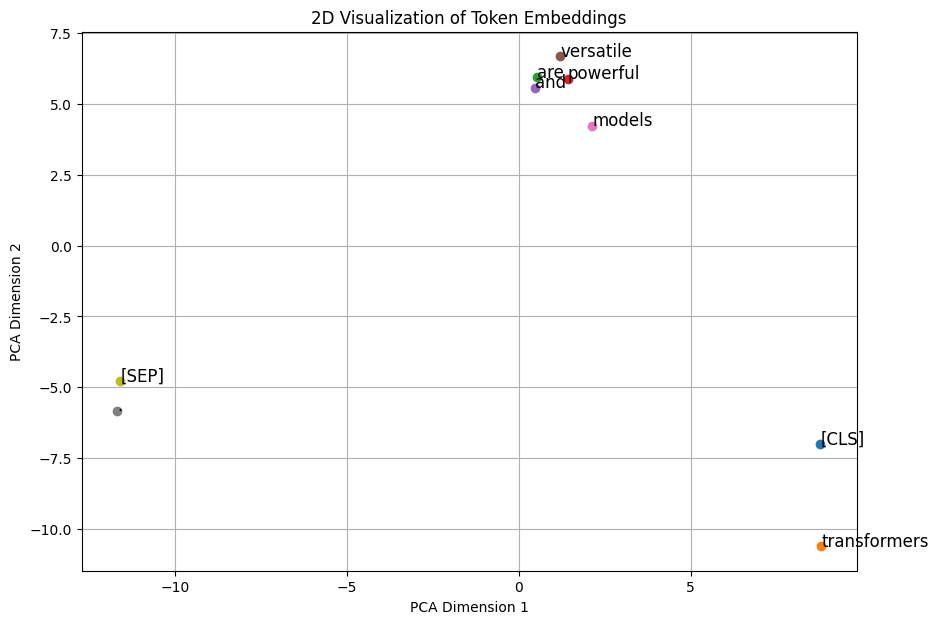

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(token_embeddings.detach().numpy())

# Visualize the reduced embeddings
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(10, 7))
for i, token in enumerate(tokens):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1] + 0.01, token, fontsize=12)
plt.title("2D Visualization of Token Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid()
plt.show()

We see that the tokens `["are","versatile", "and", "powerful", "models"]` all have very similar embeddings. The sentence start and end tokens, in addition to `"transformers"` and the punctuation "." are embedded elsewhere.

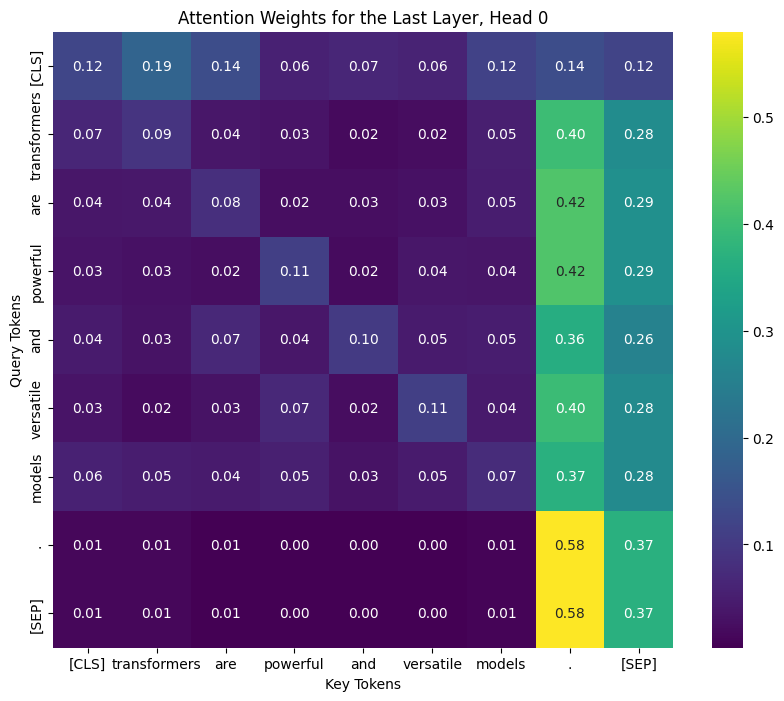

In [7]:
# Extract attention weights
attention_weights = outputs.attentions  # Shape: [num_layers, batch_size, num_heads, seq_len, seq_len]

# Example: Visualize attention from the last layer, head 0
import seaborn as sns
import numpy as np

attention_last_layer = torch.mean(outputs.attentions[-1][0], dim=0).detach().numpy()  # Shape: [seq_len, seq_len]

plt.figure(figsize=(10, 8))
sns.heatmap(attention_last_layer, annot=True, fmt=".2f", xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Weights for the Last Layer, Head 0")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

You may notice that [CLS] and [SEP] get the strongest attention weights. `[CLS]` is typically sent to a downstream classification module to analyze the sentiment/meaning of the sequence provided. It may also be used to compare two sequences, e.g. via cosine similarity. [SEP] is usually used in sentence pair analysis; e.g. it can store information about how different two sentences are.

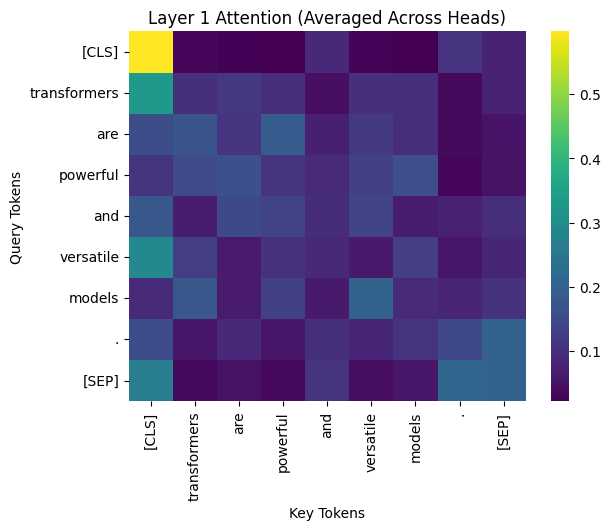

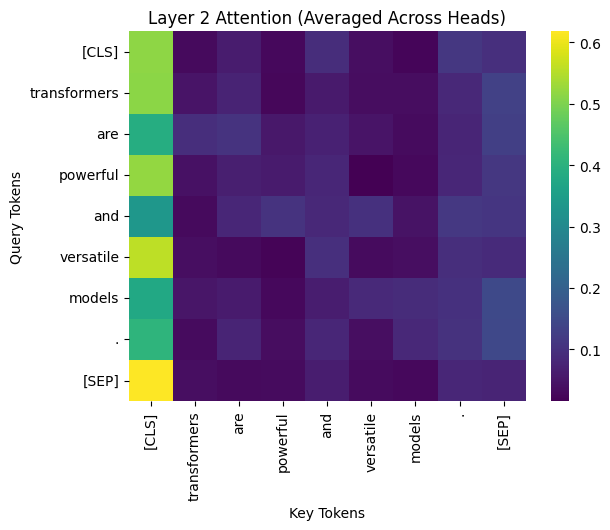

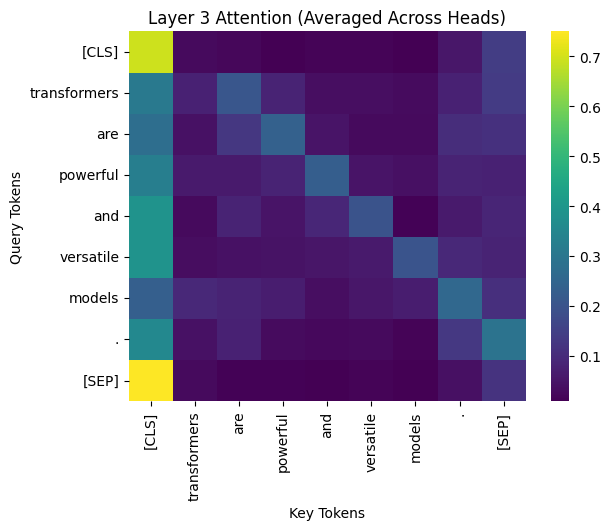

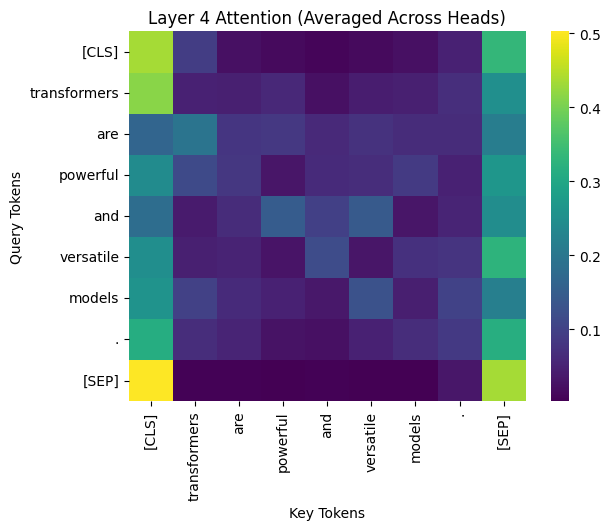

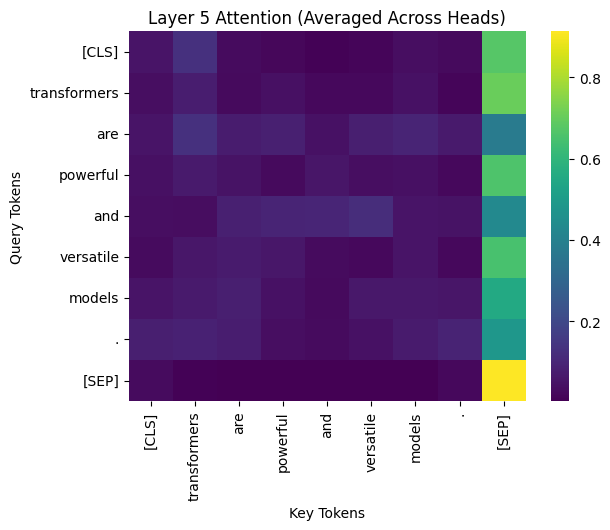

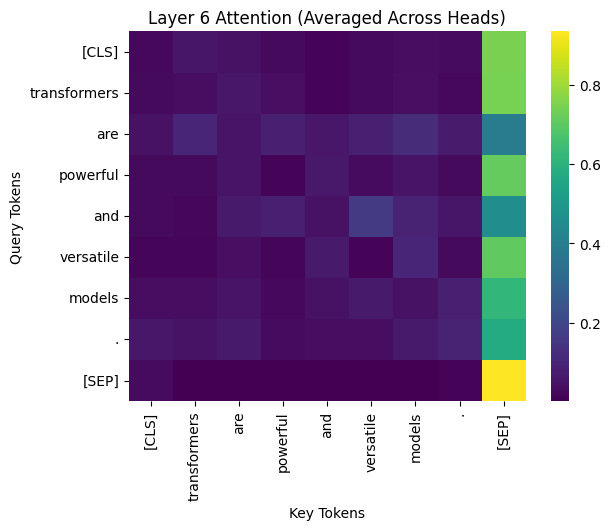

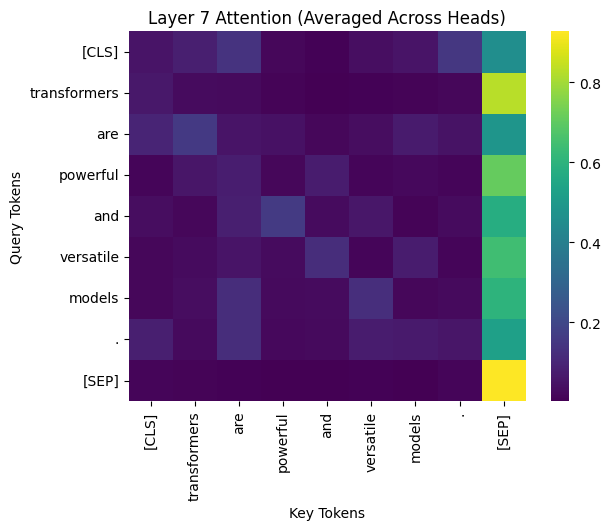

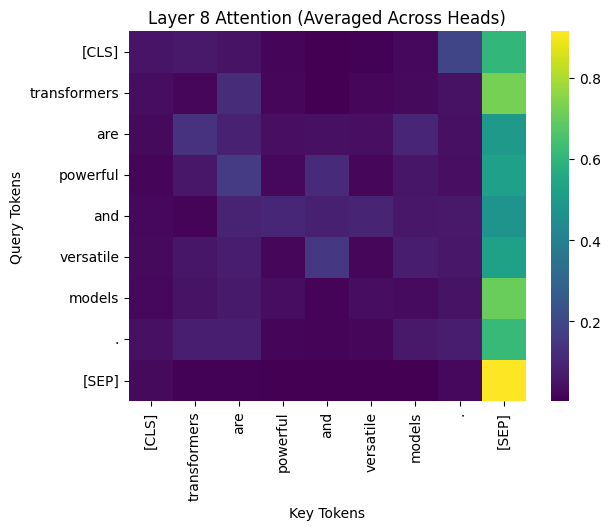

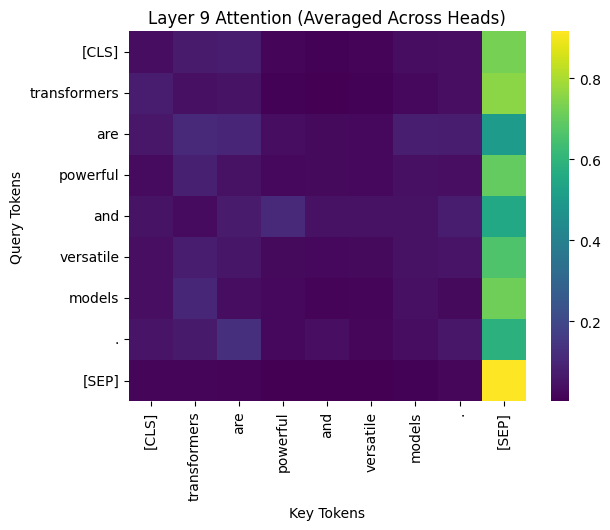

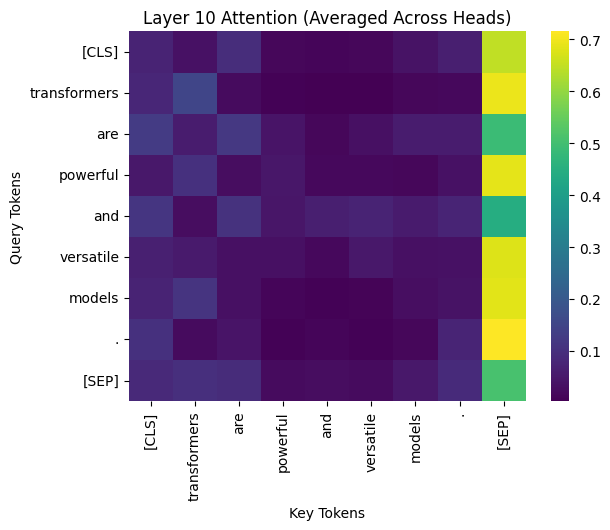

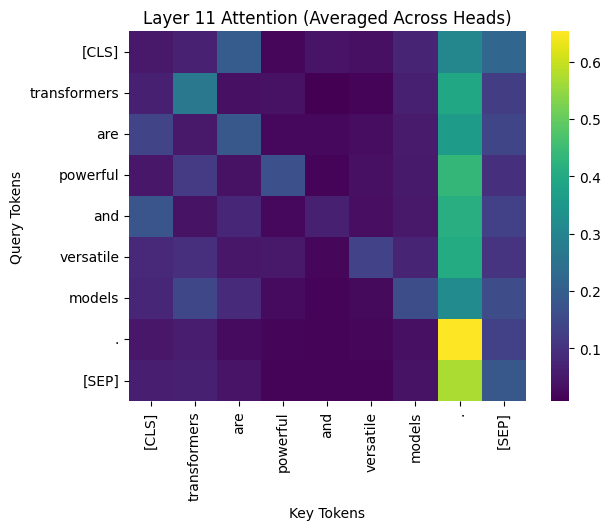

In [8]:
# Aggregate attention across heads for multiple layers
for layer_idx in range(11):
    layer_attention = torch.mean(outputs.attentions[layer_idx][0], dim=0).detach().numpy()
    sns.heatmap(layer_attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Layer {layer_idx + 1} Attention (Averaged Across Heads)")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

### 1.2 Sentence Similarity

Let's drill down on the embedding stored in `[CLS]` by evaluating several sentences that have (potentially) similar semantic structure.

In [9]:
from torch.nn import CosineSimilarity

s1 = "Transformers are powerful and versatile models."
s2 = "Language models like transformers have diverse applications."
s3 = "Political polarization keeps us divided and blind to issues that really matter."

# Tokenize and extract embeddings
cls = []
for s in [s1, s2, s3]:
  inputs = tokenizer(s, return_tensors="pt")
  outputs = model(**inputs, output_attentions=True)
  token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: [sequence_length, hidden_size]
  cls.append(token_embeddings[0])

# Cosine similarity of each sentence
cos_sim = CosineSimilarity(dim=-1)
for i in range(3):
  for j in range(3):
    print(i, j, cos_sim(cls[i], cls[j]))

0 0 tensor(1.0000, grad_fn=<SumBackward1>)
0 1 tensor(0.8939, grad_fn=<SumBackward1>)
0 2 tensor(0.8136, grad_fn=<SumBackward1>)
1 0 tensor(0.8939, grad_fn=<SumBackward1>)
1 1 tensor(1., grad_fn=<SumBackward1>)
1 2 tensor(0.8218, grad_fn=<SumBackward1>)
2 0 tensor(0.8136, grad_fn=<SumBackward1>)
2 1 tensor(0.8218, grad_fn=<SumBackward1>)
2 2 tensor(1., grad_fn=<SumBackward1>)


## 2. Fine-tuning

We've got pre-trained models like BERT available to us. These models have been trained on massive corpora and have excellent general language capabilities. Fine tuning is the process of tuning a pre-trained model, which is a much more efficient approach than re-tuning a language model from scratch.

In [67]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

!pip install evaluate
import evaluate

We're going to spin up a smaller version of BERT to fine tune.

In [54]:
# Load tokenizer and model
model_name = "distilbert-base-uncased" # "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The [IMDb dataset](https://huggingface.co/datasets/stanfordnlp/imdb) contains 50k movie reviews formatted as input sequences for downstream sentiment analysis. For example, what (0 or 1) do you think the training label would be for this review?

*National Treasure is about as over-rated and over-hyped as they come. Nicholas Cage is in no way a believable action hero, and this film is no "Indiana Jones". People who have compared this movie to the Indian Jones classic trilogy have seriously fallen off their rocker...*

In [55]:
# Load IMDb dataset
dataset = load_dataset("imdb")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [56]:
# Take a small fraction of the dataset (e.g., 10%)
fraction = 0.1
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(int(len(dataset["train"]) * fraction)))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(int(len(dataset["test"]) * fraction)))

# Verify the size
print(f"Train size: {len(small_train_dataset)}, Test size: {len(small_test_dataset)}")

# Tokenize the smaller datasets
def preprocess_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

small_train_dataset = small_train_dataset.map(preprocess_data, batched=True)
small_test_dataset = small_test_dataset.map(preprocess_data, batched=True)

# Convert to PyTorch format
small_train_dataset = small_train_dataset.rename_column("label", "labels")
small_test_dataset = small_test_dataset.rename_column("label", "labels")

small_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
small_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Train size: 2500, Test size: 2500


In [61]:
import torch

# Function to move tensors to the correct device (GPU/CPU)
def move_to_device(batch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move tensor columns to the correct device
    batch = {key: value.to(device) if torch.is_tensor(value) else value for key, value in batch.items()}
    return batch

# Apply this function to your dataset using `map`
small_train_dataset = small_train_dataset.map(move_to_device, batched=True)
small_test_dataset = small_test_dataset.map(move_to_device, batched=True)

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [62]:
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
print("Model device:", next(model.parameters()).device)  # This should print "cuda" if using GPU

Model device: cuda:0


In [69]:
from transformers import TrainingArguments

accuracy = evaluate.load("accuracy")

from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Get the class with the highest probability
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_steps=10,
    fp16=torch.cuda.is_available(),  # Enable mixed precision if on GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-69-7afdaeb34d4b>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.009300,1.224490,0.822400
2,0.000800,1.251953,0.820800
3,0.046500,1.238116,0.829600


TrainOutput(global_step=471, training_loss=0.03432731490163034, metrics={'train_runtime': 82.7649, 'train_samples_per_second': 90.618, 'train_steps_per_second': 5.691, 'total_flos': 248376372480000.0, 'train_loss': 0.03432731490163034, 'epoch': 3.0})

In [70]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.238115668296814, 'eval_accuracy': 0.8296, 'eval_runtime': 2.2918, 'eval_samples_per_second': 1090.831, 'eval_steps_per_second': 34.47, 'epoch': 3.0}
